In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from scipy.stats import zscore
from scipy import signal

import statsmodels.api as sm
import statsmodels.formula.api as smf


In [39]:
FS = 4 # E4 sampling rate
FREQ_ARRAY = np.append(np.arange(23, 26, 1), np.arange(6*24, 9*24, 24)) # for morlet
PANDAS_RESAMPLE_RATE = "{:.4f}".format(1/FS)+'S' # find missing samples (datetime)

MODALITY = 'hr'


In [27]:
HDRS_17_CUTOFF = 20
HDRS_24_CUTOFF = 10
RCI_HDRS_17 = 6

HDRS_variant = 'hamd_17_score'

LABEL_FOLDER_PATH = 'labels/'
SAVE_CWT_FOLDER = '/media/bayesian-posterior/sdc/sensecode_data/' + MODALITY + '/cwt_' + MODALITY + '_all_freq/'

DATA_FOLDER_PATH = '/media/bayesian-posterior/sdc/sensecode_data/' + MODALITY + '/'
DATA_FOLDER = os.fsencode(DATA_FOLDER_PATH)

In [28]:
def get_x_y(df, 
            subject,
            HDRS_df, 
            HDRS_variant, 
            test_freq = str(1.0*24)):
    
    resampled_df = df[test_freq].resample('D').mean()
    resampled_df.index = resampled_df.index.tz_localize(None)
    # print(resampled_df.index)

    t = resampled_df.index.to_pydatetime()
    E4_start_date = t[0]
    E4_end_date = t[-1]

    # assert len(HDRS_array) == len(HDRS_date)
    x, y = [], []
    HDRS_date = HDRS_df['Date']
    
    for idx in range(len(HDRS_date)):

        # left = datetime.strptime(HDRS_date.iloc[idx - 1], '%Y-%m-%d %H:%M:%S')
        date = datetime.strptime(HDRS_date.iloc[idx], '%Y-%m-%d %H:%M:%S')
        
        if date < E4_start_date:
            continue
        elif date <= E4_end_date:
            if idx == 0:
                left = E4_start_date
            else:
                prev_date = datetime.strptime(HDRS_date.iloc[idx - 1], '%Y-%m-%d %H:%M:%S')
                if prev_date < E4_start_date:
                    left = E4_start_date
                else:
                    left = prev_date
            right = date
        else:
            prev_date = datetime.strptime(HDRS_date.iloc[idx - 1], '%Y-%m-%d %H:%M:%S')
            if prev_date >= E4_end_date:
                break
            else:
                left = prev_date
                right = E4_end_date
        
        # left.strftime('%Y-%m-%d')
        # left = right - timedelta(days = 1)
        segment = resampled_df.loc[left : right]    
        # segment = resampled_df.loc[right] 
        power = np.mean(segment)
        # print(power, type(power))

        x.append(power)
        y.append(HDRS_df[HDRS_variant].iloc[idx])
        
    return x, y

In [29]:
# dummy_hdrs_list, dummy_power_list, dummy_subject_list = [], [], []

# for file in os.listdir(SAVE_CWT_FOLDER):
    
#     filename = os.fsdecode(file)
    
#     if filename.endswith("cwt.h5"):
        
#         subject = filename.split('_')[0]
#         eda_filepath = SAVE_CWT_FOLDER+filename
#         df_cwt = pd.read_hdf(eda_filepath, 'df')
#         # print(subject)
        
#         HDRS_file_name = LABEL_FOLDER_PATH + subject + '_HDRS.csv'
#         HDRS_df = pd.read_csv(HDRS_file_name)
#         HDRS_df.dropna(inplace = True) # in case of missed HDRS assessment
#         HDRS_df = HDRS_df.reset_index()      
        
#         x, y = get_x_y(df_cwt, 
#                         subject = subject,
#                         HDRS_df = HDRS_df, 
#                        HDRS_variant = HDRS_variant)
        
#         x.sort()
#         y.sort(reverse = True)
        
#         dummy_hdrs_list += y
#         dummy_power_list += x
#         dummy_subject_list += [subject] * len(y)
        
        
# df_lmm = pd.DataFrame({HDRS_variant : dummy_hdrs_list, 'power' : dummy_power_list, 'subject' : dummy_subject_list})

In [30]:
def plot_lmm(lmm, df_lmm):
    
    grouped_df_lmm = df_lmm.groupby('subject')
    num_subject = len(grouped_df_lmm)
    assert num_subject == 35
    
    fixed_intercept = mdf.fe_params['Intercept']
    fixed_slope = mdf.fe_params['power']
    
    fig, axs = plt.subplots(7, 5, figsize=(20, 20))
    fig.tight_layout()
    count = 0
    
    for subject, subject_df in grouped_df_lmm:

        random_intercept = mdf.random_effects[subject][0]
        hdrs_array = subject_df[HDRS_variant]
        power_array = subject_df['power']
        
        row, col = divmod(count, 5)        
        count += 1
        
        axs[row, col].scatter(power_array, 
                              hdrs_array)
        
        axs[row, col].plot(power_array, 
                fixed_intercept + random_intercept + fixed_slope * power_array, 
                alpha = 0.5)
        
        axs[row, col].set_title(subject)

In [40]:
lmm_df_name = 'lmm_' + MODALITY + '_data.csv'


In [41]:
df_lmm = pd.read_csv(lmm_df_name)  

In [42]:
function = HDRS_variant + ' ~ power'

md = smf.mixedlm(function, 
                 df_lmm, 
                 groups = df_lmm['subject'])

mdf = md.fit(method=["lbfgs"])
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: hamd_17_score
No. Observations: 433     Method:             REML         
No. Groups:       35      Scale:              15.9806      
Min. group size:  8       Log-Likelihood:     -1271.0317   
Max. group size:  13      Converged:          Yes          
Mean group size:  12.4                                     
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    12.954     0.887  14.605  0.000  11.216  14.692
power         0.004     0.002   2.340  0.019   0.001   0.008
Group Var    25.572     1.702                               
===========================================================

"""

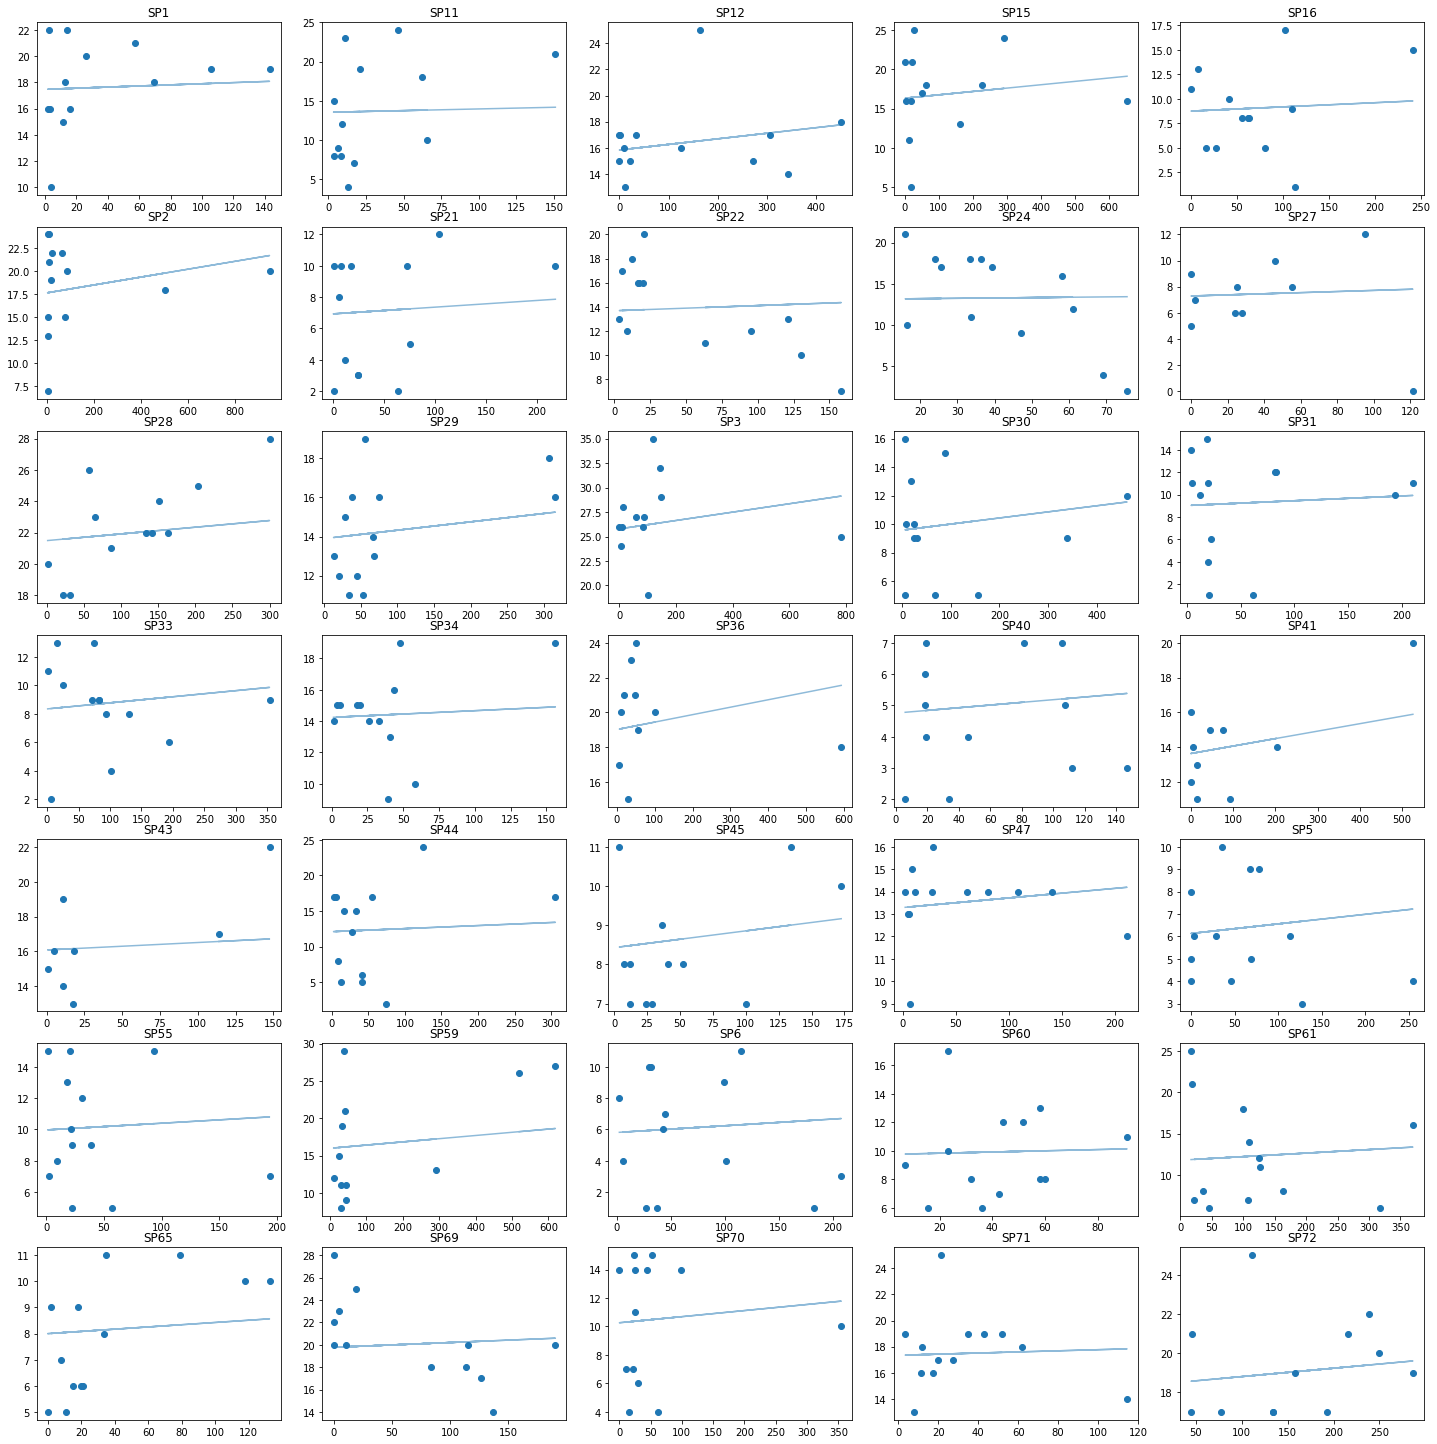

In [43]:
plot_lmm(mdf, df_lmm)

In [ ]:

# df_lmm.to_csv(lmm_df_name, index=False) 